In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import cv2
import matplotlib.pyplot as plt
import os
from PIL import Image
import numpy as np
import pandas as pd

In [ ]:
os.chdir('/content/drive/MyDrive/forest_fire_dataset/mask')
lst = os.listdir('/content/drive/MyDrive/forest_fire_dataset/mask')
print(lst)

['2_30_391.png', '2_30_4.png', '2_30_432.png', '2_30_433.png', '2_30_438.png', '2_30_439.png', '2_30_441.png', '2_30_450.png', '2_30_458.png', '2_30_456.png', '2_30_463.png', '2_30_462.png', '2_30_482.png', '2_30_487.png', '2_30_517.png', '2_30_6.png', '2_30_617.png', '2_30_618.png', '2_30_622.png', '2_30_619.png', '2_30_623.png', '2_30_624.png', '2_30_625.png', '2_30_626.png', '2_30_627.png', '2_30_628.png', '2_30_629.png', '2_30_630.png', '2_30_631.png', '2_30_632.png', '2_30_634.png', '2_30_636.png', '2_30_635.png', '2_30_637.png', '2_30_638.png', '2_30_639.png', '2_30_642.png', '2_30_645.png', '2_30_644.png', '2_30_643.png', '2_30_646.png', '2_30_647.png', '2_30_649.png', '2_30_648.png', '2_30_651.png', '2_30_652.png', '2_30_653.png', '2_30_654.png', '2_30_655.png', '2_30_657.png', '2_30_659.png', '2_30_661.png', '2_30_663.png', '2_30_664.png', '2_30_665.png', '2_30_667.png', '2_30_670.png', '2_30_671.png', '2_30_674.png', '2_30_679.png', '2_30_680.png', '2_30_681.png', '2_30_682.p

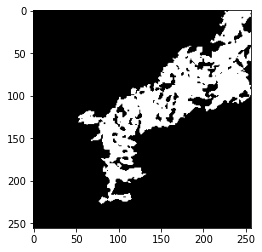

In [ ]:
a = cv2.imread("/content/drive/MyDrive/forest_fire_dataset/mask/1_20_4.png")
plt.imshow(a)

In [ ]:
from google.colab.patches import cv2_imshow

In [ ]:
mask = []
img = []
for filename in lst:
    if filename.endswith('.png'):
        img.append(filename)
        mask.append(filename)

In [ ]:
len(img)

3076

In [ ]:
y = np.zeros((3076, 224, 224), dtype=np.float32)
X = np.zeros((3076, 224, 224, 1), dtype=np.float32)

In [ ]:
for i in img:
    index = img.index(i)
    dir_img = os.path.join('/content/drive/MyDrive/forest_fire_dataset/og', i)
    im = Image.open(dir_img)
    im = im.resize((224, 224))
    im = np.reshape(im.convert('L'), (224,224,1))
    X[index] = im
    m = mask[index]
    dir_mask = os.path.join('/content/drive/MyDrive/forest_fire_dataset/mask', m)
    mask_img = cv2.imread(dir_mask)
    #mask_img = (mask_img!=2)*1.0
    mask_img = cv2.resize(mask_img, (224, 224))
    mask_img = 1.0*(mask_img[:,:,0]>0.2)
    y[index] = mask_img

In [ ]:
!pip install git+https://github.com/qubvel/segmentation_models

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/qubvel/segmentation_models to /tmp/pip-req-build-majobd6v
  Running command git clone -q https://github.com/qubvel/segmentation_models /tmp/pip-req-build-majobd6v
  Running command git submodule update --init --recursive -q
     |████████████████████████████████| 50 kB 4.1 MB/s 
  Created wheel for segmentation-models: filename=segmentation_models-1.0.1-py3-none-any.whl size=33810 sha256=bd86afb7c48802a76d7c895783ac1b2abd7a659f80ebc9d7a6807b57c7cbd616
  Stored in directory: /tmp/pip-ephem-wheel-cache-obfj803h/wheels/02/cd/18/61c0bbb8766acfec68f9d20618886b7b38dfeeb95865b6ba00
Successfully built segmentation-models


In [ ]:
from segmentation_models import Unet
from segmentation_models import get_preprocessing
from segmentation_models.losses import bce_jaccard_loss
from segmentation_models.metrics import iou_score
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.models import model_from_json

from tensorflow.keras.layers import Input, Conv2D, Reshape, BatchNormalization, MaxPooling2D, concatenate, Conv2DTranspose
from tensorflow.keras.models import Model

Segmentation Models: using `keras` framework.


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
BACKBONE = 'resnet34'
preprocess_input = get_preprocessing(BACKBONE)
X_train = preprocess_input(X_train)
X_test = preprocess_input(X_test)

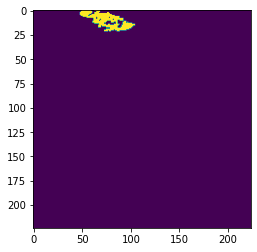

In [ ]:
plt.imshow(y_train[0])

In [ ]:
from tensorflow.keras import layers

In [ ]:
from tensorflow.keras.layers import Reshape
N = X_train.shape[-1]

In [ ]:
import segmentation_models as sm
sm.set_framework('tf.keras')
sm.framework()

'tf.keras'

In [ ]:
inputs = Input((224, 224, N))
bnorm1 = BatchNormalization()(inputs)
conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(bnorm1)
conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)

up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)

up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)

conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

model = Model(inputs=[inputs], outputs=[conv10])

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 1  0           []                               
                                )]                                                                
                                                                                                  
 batch_normalization (BatchNorm  (None, 224, 224, 1)  4          ['input_1[0][0]']                
 alization)                                                                                       
                                                                                                  
 conv2d (Conv2D)                (None, 224, 224, 32  320         ['batch_normalization[0][0]']    
                                )                                                             

In [ ]:
from tensorflow.keras import backend as K
from tensorflow.keras.losses import binary_crossentropy

SMOOTH = 1.

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + SMOOTH) / (K.sum(y_true_f) + K.sum(y_pred_f) + SMOOTH)

def bce_dice_loss(y_true, y_pred):
    return 0.5 * binary_crossentropy(y_true, y_pred) - dice_coef(y_true, y_pred)

In [ ]:
#from tensorflow.keras.optimizers import Adam
model.compile(Adam(lr=0.0001),
              bce_dice_loss,
              metrics=[binary_crossentropy, dice_coef])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
%time history = model.fit(X_train,y_train,batch_size=32,epochs=100,validation_data=(X_test, y_test))

Epoch 1/100
77/77 [==============================] - 66s 563ms/step - loss: 0.0699 - binary_crossentropy: 0.3919 - dice_coef: 0.1261 - val_loss: 0.1187 - val_binary_crossentropy: 0.4030 - val_dice_coef: 0.0823
Epoch 2/100
77/77 [==============================] - 38s 491ms/step - loss: -0.0769 - binary_crossentropy: 0.2553 - dice_coef: 0.2046 - val_loss: -0.0291 - val_binary_crossentropy: 0.2635 - val_dice_coef: 0.1576
Epoch 3/100
77/77 [==============================] - 39s 507ms/step - loss: -0.1314 - binary_crossentropy: 0.2472 - dice_coef: 0.2550 - val_loss: -0.1031 - val_binary_crossentropy: 0.2450 - val_dice_coef: 0.2204
Epoch 4/100
77/77 [==============================] - 38s 497ms/step - loss: -0.1912 - binary_crossentropy: 0.2476 - dice_coef: 0.3150 - val_loss: -0.2003 - val_binary_crossentropy: 0.2232 - val_dice_coef: 0.3038
Epoch 5/100
77/77 [==============================] - 39s 504ms/step - loss: -0.2252 - binary_crossentropy: 0.2426 - dice_coef: 0.3465 - val_loss: -0.2240 

In [ ]:
%time model.evaluate(X_test, y_test)

20/20 [==============================] - 3s 148ms/step - loss: -0.5752 - binary_crossentropy: 0.1946 - dice_coef: 0.6540
CPU times: user 714 ms, sys: 188 ms, total: 902 ms
Wall time: 3.24 s


[-0.5751533508300781, 0.1945599913597107, 0.6539558172225952]

In [ ]:
train_loss = history.history['loss']
train_bc = history.history['binary_crossentropy']
train_dice = history.history['dice_coef']
val_loss = history.history['val_loss']
val_bc = history.history['val_binary_crossentropy']
val_dice = history.history['val_dice_coef']
print('Average training loss: ', np.mean(train_loss))
print('Average training binary crossentropy: ', np.mean(train_bc))
print('Average training dice score: ', np.mean(train_dice))
print('Average validation loss: ', np.mean(val_loss))
print('Average validation binary crossentropy: ', np.mean(val_bc))
print('Average validation dice score: ', np.mean(val_dice))

Average training loss:  -0.6767125552520156
Average training binary crossentropy:  0.11506290119141341
Average training dice score:  0.7342518977820873
Average validation loss:  -0.48514408729970454
Average validation binary crossentropy:  0.21916751101613044
Average validation dice score:  0.596066633015871


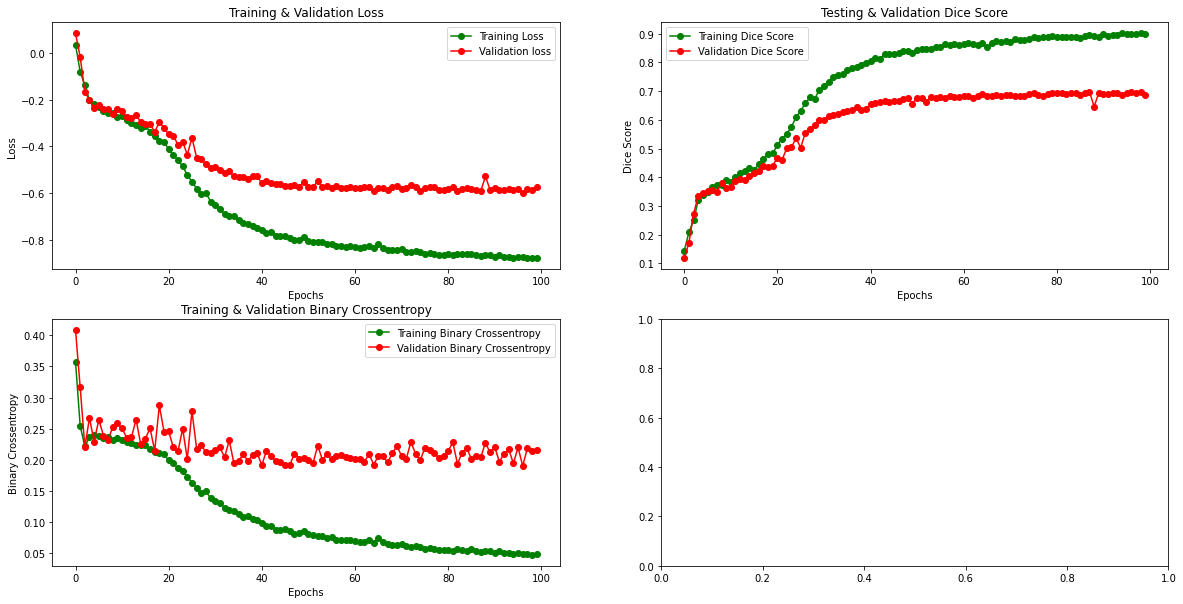

In [ ]:
epochs = [i for i in range(100)]
fig , ax = plt.subplots(2,2)
fig.set_size_inches(20,10)

ax[0][0].plot(epochs , train_loss , 'go-' , label = 'Training Loss')
ax[0][0].plot(epochs , val_loss , 'ro-' , label = 'Validation loss')
ax[0][0].set_title('Training & Validation Loss')
ax[0][0].legend()
ax[0][0].set_xlabel("Epochs")
ax[0][0].set_ylabel("Loss")

ax[1][0].plot(epochs , train_bc , 'go-' , label = 'Training Binary Crossentropy')
ax[1][0].plot(epochs , val_bc , 'ro-' , label = 'Validation Binary Crossentropy')
ax[1][0].set_title('Training & Validation Binary Crossentropy')
ax[1][0].legend()
ax[1][0].set_xlabel("Epochs")
ax[1][0].set_ylabel("Binary Crossentropy")

ax[0][1].plot(epochs , train_dice , 'g-o' , label = 'Training Dice Score')
ax[0][1].plot(epochs , val_dice , 'r-o' , label = 'Validation Dice Score')
ax[0][1].set_title('Testing & Validation Dice Score')
ax[0][1].legend()
ax[0][1].set_xlabel("Epochs")
ax[0][1].set_ylabel("Dice Score")
plt.show()

In [ ]:
from keras.models import model_from_json
model_json = model.to_json()

with open("model.json", "w") as json_file:
    json_file.write(model_json)
model.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk


In [ ]:
training_pred = model.predict(X_train)
testing_pred = model.predict(X_test)

In [ ]:
import imageio

In [ ]:
X_test.shape

(616, 224, 224, 1)

In [ ]:
X_train.shape

(2460, 224, 224, 1)

In [ ]:
model.save('/content/drive/MyDrive/forest_fire_dataset/unet.h5')

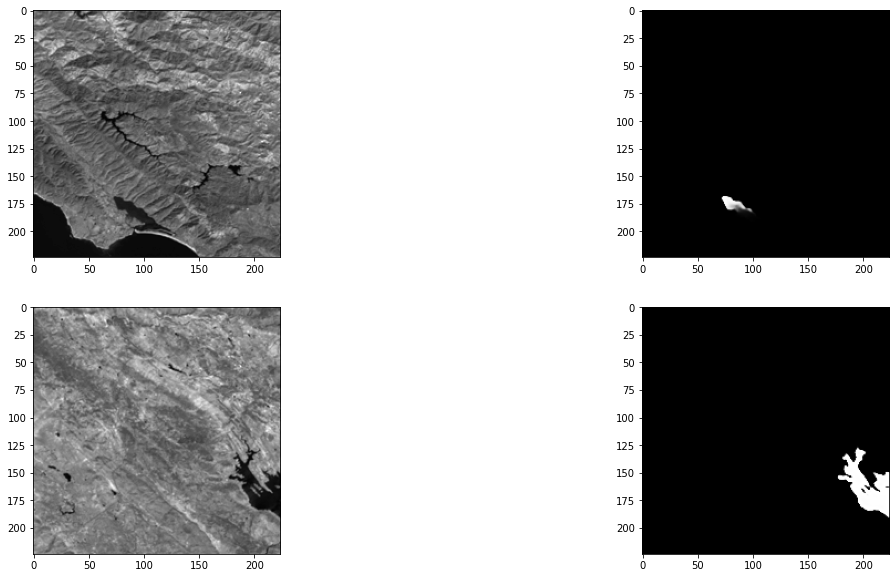

In [ ]:
fig = plt.figure(0, figsize=(20, 10))
k = 3
scale = 255
fig.add_subplot(2, 2, 1)
plt.imshow(np.squeeze(X_train[k]), cmap='gray')
fig.add_subplot(2, 2, 2)
plt.imshow(np.squeeze(training_pred[k] * scale), cmap='gray')
fig.add_subplot(2, 2, 3)
plt.imshow(np.squeeze(X_train[k+1]), cmap='gray')
fig.add_subplot(2, 2, 4)
plt.imshow(np.squeeze(training_pred[k+1] * scale), cmap='gray')

0


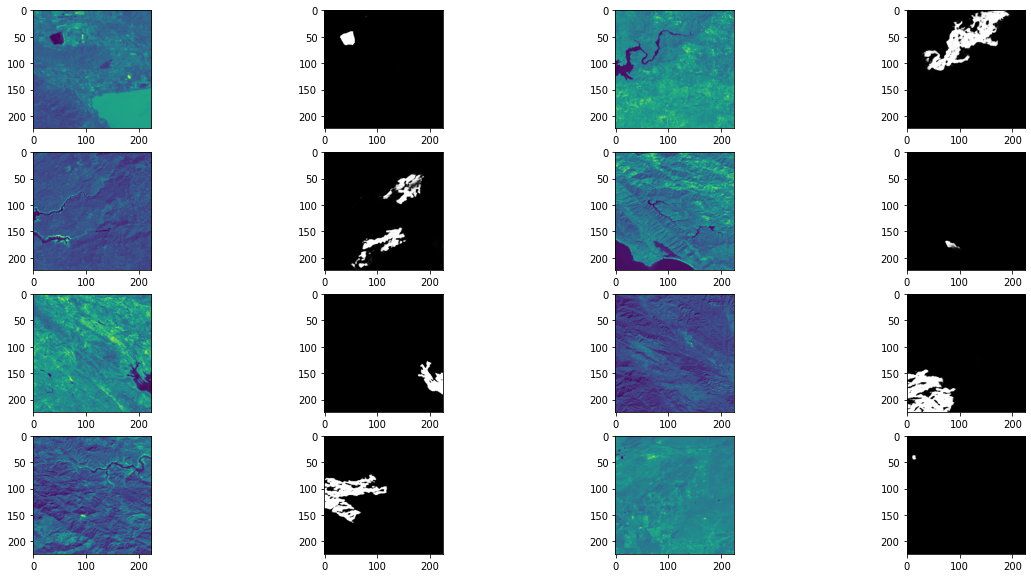

In [ ]:
fig = plt.figure(0, figsize=(20, 10))
#k = random.randint(0, 3000)
k = 0
print(k)
scale = 255
fig.add_subplot(4, 4, 1)
plt.imshow(np.squeeze(X_train[k]))
fig.add_subplot(4, 4, 2)
plt.imshow(np.squeeze(training_pred[k] * scale), cmap='gray')
fig.add_subplot(4, 4, 3)
plt.imshow(np.squeeze(X_train[k+1]))
fig.add_subplot(4, 4, 4)
plt.imshow(np.squeeze(training_pred[k+1] * scale), cmap='gray')
fig.add_subplot(4, 4, 5)
plt.imshow(np.squeeze(X_train[k+2]))
fig.add_subplot(4, 4, 6)
plt.imshow(np.squeeze(training_pred[k+2] * scale), cmap='gray')
fig.add_subplot(4, 4, 7)
plt.imshow(np.squeeze(X_train[k+3]))
fig.add_subplot(4, 4, 8)
plt.imshow(np.squeeze(training_pred[k+3] * scale), cmap='gray')
fig.add_subplot(4, 4, 9)
plt.imshow(np.squeeze(X_train[k+4]))
fig.add_subplot(4, 4, 10)
plt.imshow(np.squeeze(training_pred[k+4] * scale), cmap='gray')
fig.add_subplot(4, 4, 11)
plt.imshow(np.squeeze(X_train[k+5]))
fig.add_subplot(4, 4, 12)
plt.imshow(np.squeeze(training_pred[k+5] * scale), cmap='gray')
fig.add_subplot(4, 4, 13)
plt.imshow(np.squeeze(X_train[k+6]))
fig.add_subplot(4, 4, 14)
plt.imshow(np.squeeze(training_pred[k+6] * scale), cmap='gray')
fig.add_subplot(4, 4, 15)
plt.imshow(np.squeeze(X_train[k+7]))
fig.add_subplot(4, 4, 16)
plt.imshow(np.squeeze(training_pred[k+7] * scale), cmap='gray')

0


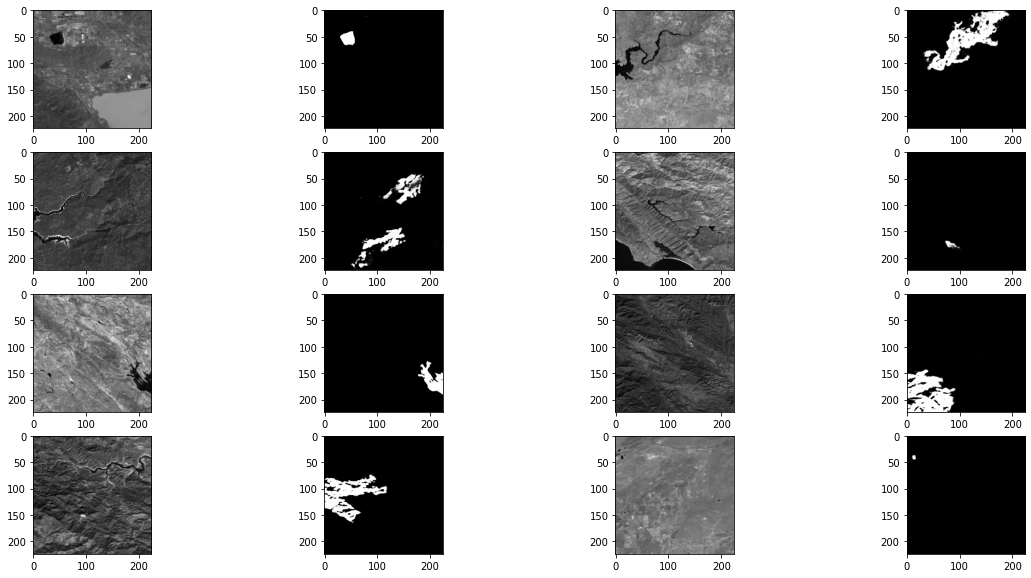

In [ ]:
fig = plt.figure(0, figsize=(20, 10))
#k = random.randint(0, 3000)
k = 0
print(k)
scale = 255
fig.add_subplot(4, 4, 1)
plt.imshow(np.squeeze(X_train[k]), cmap='gray')
fig.add_subplot(4, 4, 2)
plt.imshow(np.squeeze(training_pred[k] * scale), cmap='gray')
fig.add_subplot(4, 4, 3)
plt.imshow(np.squeeze(X_train[k+1]), cmap='gray')
fig.add_subplot(4, 4, 4)
plt.imshow(np.squeeze(training_pred[k+1] * scale), cmap='gray')
fig.add_subplot(4, 4, 5)
plt.imshow(np.squeeze(X_train[k+2]), cmap='gray')
fig.add_subplot(4, 4, 6)
plt.imshow(np.squeeze(training_pred[k+2] * scale), cmap='gray')
fig.add_subplot(4, 4, 7)
plt.imshow(np.squeeze(X_train[k+3]), cmap='gray')
fig.add_subplot(4, 4, 8)
plt.imshow(np.squeeze(training_pred[k+3] * scale), cmap='gray')
fig.add_subplot(4, 4, 9)
plt.imshow(np.squeeze(X_train[k+4]), cmap='gray')
fig.add_subplot(4, 4, 10)
plt.imshow(np.squeeze(training_pred[k+4] * scale), cmap='gray')
fig.add_subplot(4, 4, 11)
plt.imshow(np.squeeze(X_train[k+5]), cmap='gray')
fig.add_subplot(4, 4, 12)
plt.imshow(np.squeeze(training_pred[k+5] * scale), cmap='gray')
fig.add_subplot(4, 4, 13)
plt.imshow(np.squeeze(X_train[k+6]), cmap='gray')
fig.add_subplot(4, 4, 14)
plt.imshow(np.squeeze(training_pred[k+6] * scale), cmap='gray')
fig.add_subplot(4, 4, 15)
plt.imshow(np.squeeze(X_train[k+7]), cmap='gray')
fig.add_subplot(4, 4, 16)
plt.imshow(np.squeeze(training_pred[k+7] * scale), cmap='gray')